# Knight FinTech Research Pvt Ltd.
## Solution By- Rishi Raj Gupta


In [1]:
# Imported all libraries

import pandas as pd
import numpy as np
import os, re, sys, tqdm, string, warnings
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings(action = 'ignore')
pd.set_option('max_columns',500)

In [2]:
# Read all given dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [4]:
test.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20665 entries, 0 to 20664
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           15927 non-null  object 
 1   country             20661 non-null  object 
 2   review_title        20665 non-null  object 
 3   review_description  20665 non-null  object 
 4   designation         14676 non-null  object 
 5   points              20665 non-null  int64  
 6   price               19271 non-null  float64
 7   province            20661 non-null  object 
 8   region_1            17351 non-null  object 
 9   region_2            8914 non-null   object 
 10  winery              20665 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.7+ MB


In [7]:
train.describe(include = ['object','float64','int64'])

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
count,63264,82622,82657,82657,59010,82657.000000,77088.000000,82622,69903,35949,82657,82657
unique,15,38,76983,77628,26424,NaN,NaN,358,1019,17,13786,28
top,@vossroger,US,Korbel NV Brut Sparkling (California),"Powerful, mouthwatering, concentrated black-ch...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Testarossa,Pinot Noir
freq,17539,38573,8,2,1382,NaN,NaN,25736,3334,7503,175,10587
mean,NaN,NaN,NaN,NaN,NaN,88.544564,36.922232,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.099649,43.698346,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,86.000000,18.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,88.000000,27.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,91.000000,45.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
test.describe(include = ['object','float64','int64'])

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
count,15927,20661,20665,20665,14676,20665.000000,19271.000000,20661,17351,8914,20665
unique,14,38,20298,20350,9619,NaN,NaN,272,758,17,7922
top,@vossroger,US,Chandon NV Rosé Sparkling (California),The very gentle but seductive notion of sun-ri...,Reserve,NaN,NaN,California,Napa Valley,Central Coast,Testarossa
freq,4432,9580,3,2,350,NaN,NaN,6325,824,1844,42
mean,NaN,NaN,NaN,NaN,NaN,88.524897,36.217166,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.055695,39.362644,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,86.000000,17.500000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,88.000000,27.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,91.000000,45.000000,NaN,NaN,NaN,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

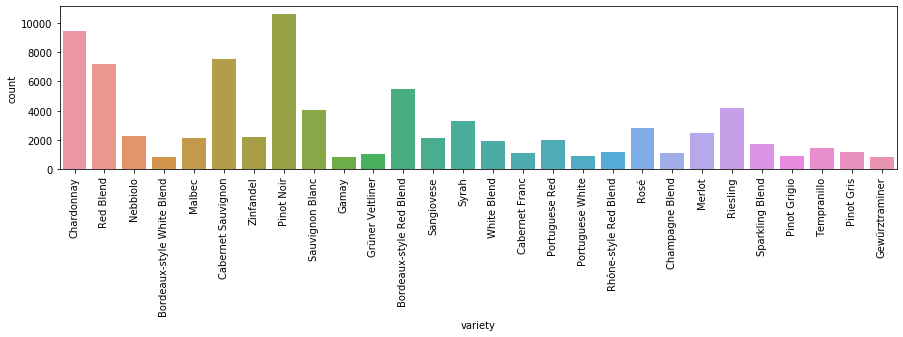

In [9]:
plt.figure(figsize = (15,3))
sns.countplot(train.variety)
plt.xticks(rotation = 90)

## Cleaning Duplicate values

While working on EDA - Found out that train and test set have lots of duplicate data. This may lead to overfitting therefore dropped all duplicate entries except first one from trainset. 

In [10]:
print(f"Train duplicate :\n{train.duplicated().value_counts()}\nTest duplicate :\n{test.duplicated().value_counts()}")
df = train.drop_duplicates(keep='first').append(test.drop_duplicates(keep='first'))
print(f"\nDuplicate values between train and test set :\n{df.duplicated().value_counts()}")

Train duplicate :
False    77641
True      5016
dtype: int64
Test duplicate :
False    20351
True       314
dtype: int64

Duplicate values between train and test set :
False    97992
dtype: int64


No duplicate entries are present between train and test set. Therefore deleting duplicate values in train set and we can't delete test set duplicate values. Therefore storing all test set duplicate rows in a variable named "duplicate". We can check in final prediction of these index values

In [11]:
train.drop_duplicates(inplace=True)
train.reset_index(drop = True, inplace = True)

duplicate = test.duplicated().index

## Price

Found out that price feature is not in standardized form. Also it contains lots of outliers. Therefore applied log transformation and then used quantile to detect outliers and deleted them with confidence of > 99%

18.59397859750221 828.434572313247
0.5977478942189535 0.7786098467847773


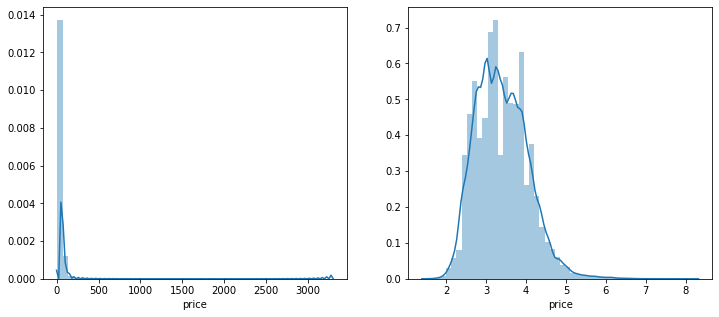

In [12]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
plt.subplot(1,2,1)
sns.distplot(train.price)
print(train.price.skew(), train.price.kurt())

plt.subplot(1,2,2)
sns.distplot(np.log1p(train.price))
print(np.log1p(train.price).skew(), np.log1p(train.price).kurt())

In [13]:
train.price = np.log1p(train.price)
test.price = np.log1p(test.price)

In [14]:
q1 = train.price.quantile(.25)
q3 = train.price.quantile(.75)
iqr = q3 - q1
upper = q3 + 2.5 * iqr
lower = q1 - 2.5 * iqr

train.price.apply(lambda x: True if x>upper or x< lower else False).value_counts()

False    77566
True        75
Name: price, dtype: int64

In [15]:
ind = train[train.price.apply(lambda x: True if x>upper or x< lower else False)].index
train.drop(index =  ind, inplace = True)
train.reset_index(drop = True, inplace = True)

# POINTS

0.010672629209913216 -0.41020321033116236


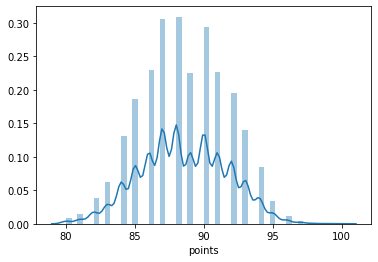

In [16]:
sns.distplot(train.points)
print(train.points.skew(), train.points.kurt())

Also tried converting points into categorical but it reduced f1 score

### COMBINING TRAIN AND TEST SET

In [17]:
df = train.append(test, sort= False).reset_index(drop = True)

In [18]:
df.duplicated().value_counts()

False    97917
True       314
dtype: int64

Here 314 duplicate values are those values which are present under test set

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98231 entries, 0 to 98230
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           74966 non-null  object 
 1   country             98194 non-null  object 
 2   review_title        98231 non-null  object 
 3   review_description  98231 non-null  object 
 4   designation         70098 non-null  object 
 5   points              98231 non-null  int64  
 6   price               91552 non-null  float64
 7   province            98194 non-null  object 
 8   region_1            82966 non-null  object 
 9   region_2            42723 non-null  object 
 10  winery              98231 non-null  object 
 11  variety             77566 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 9.0+ MB


## ANALYSIS

In [20]:
for c in df.columns :
    print(f"Unique entry for column {c} :\t\t{df[c].nunique()}")

Unique entry for column user_name :		15
Unique entry for column country :		40
Unique entry for column review_title :		94413
Unique entry for column review_description :		95359
Unique entry for column designation :		30300
Unique entry for column points :		21
Unique entry for column price :		325
Unique entry for column province :		370
Unique entry for column region_1 :		1055
Unique entry for column region_2 :		17
Unique entry for column winery :		14728
Unique entry for column variety :		28


## COUNTRY AND PROVINCE

country and province have missing values at same row.

In [21]:
df.groupby(['winery'])['country'].value_counts()[:10]

winery            country    
1+1=3             Spain           5
10 Knots          US              1
100 Percent Wine  US              2
1000 Stories      US              2
1070 Green        US              1
10Span            US              4
12 Linajes        Spain           5
12C Wines         US              5
13 Celsius        New Zealand     1
14 Hands          US             59
Name: country, dtype: int64

In [22]:
df.groupby(['province'])['country'].value_counts()[:10]

province          country 
Achaia            Greece        4
Aconcagua Costa   Chile        25
Aconcagua Valley  Chile        89
Aegean            Turkey       16
Agioritikos       Greece        2
Ahr               Germany       2
Alenquer          Portugal      7
Alentejano        Portugal    762
Alentejo          Portugal    163
Alenteo           Portugal      1
Name: country, dtype: int64

a single winery is not present across country and province. We can use winery to fill country and province null values

In [23]:
def filler(x):
    try :
        return(x.fillna(x.mode()[0]))
    except:
        pass

df.country = df.groupby(['winery'])['country'].transform(lambda x: filler(x))
df.province = df.groupby(['winery'])['province'].transform(lambda x: filler(x))

print(f'Null values in \ncountry -{df.country.isnull().value_counts()}\nprovince {df.country.isnull().value_counts()}')

Null values in 
country -False    98210
True        21
Name: country, dtype: int64
province False    98210
True        21
Name: country, dtype: int64


In [24]:
# Other missing values in country and province can't be filled with given data therefore filling Unk
df.country.fillna('Unk', inplace = True)
df.province.fillna('Unk', inplace = True)

## USER NAME

Futhermore we can fill missing user name values by using country and province. because a single user is belong to one country and province

In [25]:
df.sort_values(by = ['country','province']).groupby(['country','province']).user_name.value_counts()

country    province          user_name     
Argentina  Mendoza Province  @wineschach       2705
           Other             @wineschach        360
Armenia    Armenia           @worldwineguys       1
Australia  Australia Other   @JoeCz             130
           New South Wales   @JoeCz              33
                                               ... 
Uruguay    Juanico           @wineschach          3
           Montevideo        @wineschach          2
           Progreso          @wineschach          5
           San Jose          @wineschach          2
           Uruguay           @wineschach          9
Name: user_name, Length: 499, dtype: int64

In [26]:
# Also only a user wrote comment on a perticular winery therefore we can fill 
df.user_name = df.groupby(['country', 'province'])['user_name'].transform(lambda x: filler(x))
df.user_name = df.groupby(['winery'])['user_name'].transform(lambda x: filler(x))
df.user_name = df.user_name.fillna('Unk')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98231 entries, 0 to 98230
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           98231 non-null  object 
 1   country             98231 non-null  object 
 2   review_title        98231 non-null  object 
 3   review_description  98231 non-null  object 
 4   designation         70098 non-null  object 
 5   points              98231 non-null  int64  
 6   price               91552 non-null  float64
 7   province            98231 non-null  object 
 8   region_1            82966 non-null  object 
 9   region_2            42723 non-null  object 
 10  winery              98231 non-null  object 
 11  variety             77566 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 9.0+ MB


# REGION_2

Region_2 is only valid for US states and based on winery we will try to fill values

In [28]:
# Non US States
df[df.country != 'US'].shape[0]

52387

In [29]:
df.groupby(['country','winery','province'])['region_2'].value_counts()

country  winery              province    region_2         
US       10 Knots            California  Central Coast         1
         100 Percent Wine    California  California Other      2
         1000 Stories        California  California Other      1
         1070 Green          California  Napa                  1
         10Span              California  Central Coast         4
                                                              ..
         un4seen             California  California Other      1
         Écluse              California  Central Coast        17
         Élevée Winegrowers  Oregon      Willamette Valley     3
         Órale               California  Central Coast         1
         àMaurice            Washington  Columbia Valley      35
Name: region_2, Length: 6443, dtype: int64

In [30]:
df.region_2 = df.groupby(['country','winery','province'])['region_2'].transform(lambda x: filler(x))
df.region_2.fillna('Not_Valid', inplace = True)

# REGION_1

In [31]:
df.groupby(['country','province','region_2'])['region_1'].value_counts()[0:4]

country    province          region_2   region_1     
Argentina  Mendoza Province  Not_Valid  Mendoza          1886
                                        Uco Valley        223
                                        Tupungato         177
                                        Luján de Cuyo     151
Name: region_1, dtype: int64

can't fill values as there are lot of places are present with same province, winery, country therefore filling with Unk

In [32]:
df.region_1.fillna('Unk', inplace = True)

# Price

In [33]:
#filling missing price value with winery mean
df.price = df.groupby(['winery'])['price'].transform(lambda x: x.fillna(x.mean()))

## DESIGNATION

can't fill values as there are lot of designations are present with same province, winery, country therefore filling with Unk

In [34]:
df.designation.fillna('Unk', inplace = True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98231 entries, 0 to 98230
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           98231 non-null  object 
 1   country             98231 non-null  object 
 2   review_title        98231 non-null  object 
 3   review_description  98231 non-null  object 
 4   designation         98231 non-null  object 
 5   points              98231 non-null  int64  
 6   price               96927 non-null  float64
 7   province            98231 non-null  object 
 8   region_1            98231 non-null  object 
 9   region_2            98231 non-null  object 
 10  winery              98231 non-null  object 
 11  variety             77566 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 9.0+ MB


## Feature extraction

Review title and review description, designation are textual data. Therefore applied Tfidf vectorization and converted it into vector and then used it as a feature

In [36]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words='english', lowercase=True, use_idf=True)

sparse_title = tfidf.fit_transform(df.review_title.str.lower())
sparse_desc = tfidf.fit_transform(df.review_description.str.lower())
sparse_desig = tfidf.fit_transform(df.designation.str.lower())

Wall time: 37.3 s


In [37]:
sparse_title.shape, sparse_desc.shape, sparse_desig.shape

((98231, 390616), (98231, 2248160), (98231, 64936))

Output will be a sparse matrix. Training a sparse matrix will take lots of time. Applied PCA to reduce dimentionality by capturing all variance

In [38]:
%%time
from sklearn.decomposition import PCA, TruncatedSVD
pca = TruncatedSVD(n_components=10)
temp1 = pd.DataFrame(pca.fit_transform(sparse_title), columns = [a for a in range(10)])
print(sum(pca.explained_variance_ratio_))
temp2 = pd.DataFrame(pca.fit_transform(sparse_desc), columns = [a for a in range(10,20)])
print(sum(pca.explained_variance_ratio_))
temp3 = pd.DataFrame(pca.fit_transform(sparse_desig), columns = [a for a in range(20,30)])
print(sum(pca.explained_variance_ratio_))

df = pd.concat([df, temp1, temp2, temp3], axis = 1)

0.025403756608128557
0.006582592774056278
0.30471063866569076
Wall time: 32 s


In [39]:
df.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,@JoeCz,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,2.397895,Australia Other,South Eastern Australia,Not_Valid,Andrew Peace,Chardonnay,0.029541,-0.004836,0.000518,0.003177,-0.035798,0.001497,0.003911,0.023530,0.021071,-0.005222,0.043269,0.010781,-0.063887,0.011903,-0.004173,-0.023803,0.015492,0.008040,-0.001839,-0.013036,-2.340115e-13,2.113686e-03,4.430109e-03,4.349548e-04,1.025754e-04,4.260506e-04,2.078600e-04,1.074087e-01,8.943728e-02,-5.722680e-02
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,Unk,89,2.772589,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend,0.150305,0.124941,0.285016,-0.018947,0.020055,-0.085931,0.004452,0.021451,0.020842,0.004250,0.075719,0.039123,-0.011794,-0.070767,0.050807,-0.015361,0.008911,0.019875,0.004866,0.069874,1.000000e+00,1.335923e-13,4.483841e-14,-2.737621e-14,-2.429300e-16,-1.641830e-15,3.286368e-15,4.586763e-15,-2.268897e-14,1.586156e-14
2,@kerinokeefe,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,4.394449,Piedmont,Barolo,Not_Valid,Renato Ratti,Nebbiolo,0.007067,0.002344,-0.001063,-0.001122,-0.007146,-0.000654,0.002008,-0.000518,0.003284,0.004419,0.067730,0.043997,0.006624,-0.002969,-0.020534,-0.014241,0.021552,0.003375,0.028959,-0.001291,-3.844702e-17,2.099176e-08,2.532088e-08,2.110093e-07,1.016892e-08,1.339685e-07,6.026831e-06,8.909947e-07,9.772915e-07,-3.386994e-07
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,3.135494,Southwest France,Bergerac Sec,Not_Valid,Domaine l'Ancienne Cure,Bordeaux-style White Blend,0.009581,0.000923,-0.000378,-0.002987,-0.020020,-0.004411,0.013789,-0.006214,0.000349,0.009374,0.037101,-0.000237,-0.003060,-0.035284,0.040356,-0.016137,-0.003009,0.010618,-0.012693,0.004641,1.258409e-16,3.723140e-07,4.929557e-07,3.720811e-06,-2.251285e-07,3.066508e-04,-6.847561e-06,6.282774e-06,7.833385e-06,-1.423979e-05
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,3.526361,France Other,Vin de Liqueur,Not_Valid,Château du Cèdre,Malbec,0.013160,0.001609,0.000948,-0.005133,-0.035108,-0.003504,0.021649,-0.013658,0.003828,0.020850,0.110082,-0.018629,0.022980,-0.013423,-0.038248,-0.023256,0.021058,0.016372,0.038041,0.012699,2.838318e-15,2.028679e-04,9.941381e-05,1.430991e-04,3.580529e-04,6.107182e-03,2.649196e-04,-2.490258e-05,1.063596e-04,-7.459556e-04


In [40]:
df.country.value_counts().index

Index(['US', 'France', 'Italy', 'Portugal', 'Chile', 'Spain', 'Argentina',
       'Austria', 'Germany', 'New Zealand', 'Australia', 'South Africa',
       'Israel', 'Canada', 'Greece', 'Bulgaria', 'Romania', 'England',
       'Slovenia', 'Mexico', 'Hungary', 'Moldova', 'Brazil', 'Turkey',
       'Uruguay', 'Lebanon', 'Morocco', 'Unk', 'Croatia', 'Georgia', 'Ukraine',
       'Peru', 'Cyprus', 'Serbia', 'Macedonia', 'Czech Republic', 'Luxembourg',
       'Switzerland', 'India', 'Slovakia', 'Armenia'],
      dtype='object')

#### Creating feature to get continent from country

In [41]:
# Creating feature to get continent from country

continent = {'US':'America', 'Chile':'South America', 'Argentina': 'South America',
       'New Zealand': 'Australia', 'Australia': 'Australia', 'South Africa': 'Africa',
       'Israel': 'Asia', 'Canada':'America', 'Mexico': 'America', 'Brazil': 'South America',
       'Lebanon': 'Asia', 'Unk': 'Unk', 'Morocco':'Africa', 'Peru':'South America', 'India':'Asia', 'Armenia':'Asia'}

df['continent'] = df.country.apply(lambda x: continent.get(x,'Europe'))

In [42]:
# filling remaining missing values with median in numerical feature and with mode in categorical features
for c in df.drop(columns = 'variety').columns:
    if df[c].values.dtype == 'O' :
        df[c].fillna(df[c].mode()[0], inplace = True)
    else :
        df[c].fillna(df[c].median(), inplace = True)

In [43]:
# Encoded categorical variable with label encoder
from sklearn.preprocessing import LabelEncoder
for c in df.drop(columns = 'variety').columns:
    if df[c].values.dtype == 'O':
        le = LabelEncoder()
        df[c] = pd.DataFrame(le.fit_transform(df[c]), columns = [c])

In [44]:
train.shape, test.shape

((77566, 12), (20665, 11))

In [45]:
train = df[df.variety.notnull()].reset_index(drop = True)
test = df[df.variety.isnull()].reset_index(drop = True)

label = train.variety
del train['variety']
del test['variety']

In [46]:
train.shape , test.shape, label.shape

((77566, 42), (20665, 42), (77566,))

# Building a classifier

In [47]:
def folds(train, label, model, lg_boost = None, param = None, testset = None):
    list_test = []
    predicted = pd.DataFrame(np.zeros(shape = (len(label))))
    predicted_prob = pd.DataFrame(np.zeros(shape=(len(label),28)))
    
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=546)
    for t_ind, v_ind in kfold.split(train.values, label):
        xtrain , ytrain = train.loc[t_ind,:], label[t_ind]
        xval , yval = train.loc[v_ind,:], label[v_ind]
        
        
        if lg_boost is not None :
            training = lgb.Dataset(xtrain, ytrain)
            testing = lgb.Dataset(xval, yval, reference=training)
            model = lgb.train(param , training, valid_sets = [training,testing],
                             num_boost_round = 1500, early_stopping_rounds = 200, verbose_eval = 5)
            predicted_prob.loc[v_ind,:] = model.predict(xval, best_iteration= model.best_iteration)
            list_test.append(model.predict(testset, best_iteration = model.best_iteration))
        
        else :
            model.fit(xtrain, ytrain)
            predicted.loc[v_ind,0] = model.predict(xval)
            list_test.append(model.predict(testset))

    if lg_boost is not None :
        print('Confusion Matrix Report:\n%s' %(confusion_matrix(np.argmax(predicted_prob.values,1),label)))
        print('Classification Report:\n%s'  %(classification_report(np.argmax(predicted_prob.values,1),label)))
        print('F1 Score : %s' %(f1_score(np.argmax(predicted_prob.values,1), label, average='weighted')))
        print('Accuracy Score : %s' %(accuracy_score(np.argmax(predicted_prob.values,1), label)))
        lgb.plot_importance(model)
        
    else :
        print('Confusion Matrix Report:\n%s' %(confusion_matrix(predicted,label)))
        print('Classification Report:\n%s' %(classification_report(predicted,label)))
        print('F1 Score : %s' %(f1_score(predicted, label, average='weighted')))
        print('Accuracy Score : %s' %(accuracy_score(predicted, label)))
        
    
    value = model.predict(testset, best_iteration = model.best_iteration)
    return(value)

Training until validation scores don't improve for 200 rounds
[5]	training's multi_logloss: 1.32701	valid_1's multi_logloss: 1.39566
[10]	training's multi_logloss: 0.899725	valid_1's multi_logloss: 0.992987
[15]	training's multi_logloss: 0.654682	valid_1's multi_logloss: 0.761755
[20]	training's multi_logloss: 0.497946	valid_1's multi_logloss: 0.615561
[25]	training's multi_logloss: 0.39163	valid_1's multi_logloss: 0.518388
[30]	training's multi_logloss: 0.316577	valid_1's multi_logloss: 0.451335
[35]	training's multi_logloss: 0.261854	valid_1's multi_logloss: 0.40348
[40]	training's multi_logloss: 0.220133	valid_1's multi_logloss: 0.367992
[45]	training's multi_logloss: 0.18771	valid_1's multi_logloss: 0.341152
[50]	training's multi_logloss: 0.162797	valid_1's multi_logloss: 0.321527
[55]	training's multi_logloss: 0.142664	valid_1's multi_logloss: 0.305583
[60]	training's multi_logloss: 0.126047	valid_1's multi_logloss: 0.293173
[65]	training's multi_logloss: 0.112214	valid_1's multi_

[165]	training's multi_logloss: 0.0236485	valid_1's multi_logloss: 0.221995
[170]	training's multi_logloss: 0.0222652	valid_1's multi_logloss: 0.221504
[175]	training's multi_logloss: 0.0210342	valid_1's multi_logloss: 0.221391
[180]	training's multi_logloss: 0.0198513	valid_1's multi_logloss: 0.221368
[185]	training's multi_logloss: 0.0187164	valid_1's multi_logloss: 0.221238
[190]	training's multi_logloss: 0.0177025	valid_1's multi_logloss: 0.221467
[195]	training's multi_logloss: 0.0167265	valid_1's multi_logloss: 0.221457
[200]	training's multi_logloss: 0.0158121	valid_1's multi_logloss: 0.221499
[205]	training's multi_logloss: 0.0149776	valid_1's multi_logloss: 0.221772
[210]	training's multi_logloss: 0.0142048	valid_1's multi_logloss: 0.221971
[215]	training's multi_logloss: 0.0134906	valid_1's multi_logloss: 0.222256
[220]	training's multi_logloss: 0.0128221	valid_1's multi_logloss: 0.222479
[225]	training's multi_logloss: 0.0121951	valid_1's multi_logloss: 0.222725
[230]	traini

[315]	training's multi_logloss: 0.00469673	valid_1's multi_logloss: 0.234501
[320]	training's multi_logloss: 0.0044715	valid_1's multi_logloss: 0.235032
[325]	training's multi_logloss: 0.00426775	valid_1's multi_logloss: 0.235596
[330]	training's multi_logloss: 0.00406569	valid_1's multi_logloss: 0.23632
[335]	training's multi_logloss: 0.0038763	valid_1's multi_logloss: 0.237193
[340]	training's multi_logloss: 0.00368572	valid_1's multi_logloss: 0.237846
[345]	training's multi_logloss: 0.00351268	valid_1's multi_logloss: 0.238378
[350]	training's multi_logloss: 0.00334867	valid_1's multi_logloss: 0.23904
[355]	training's multi_logloss: 0.00319244	valid_1's multi_logloss: 0.239535
[360]	training's multi_logloss: 0.00305405	valid_1's multi_logloss: 0.240147
[365]	training's multi_logloss: 0.00291034	valid_1's multi_logloss: 0.240666
[370]	training's multi_logloss: 0.00277586	valid_1's multi_logloss: 0.241255
[375]	training's multi_logloss: 0.00264822	valid_1's multi_logloss: 0.2419
[380]

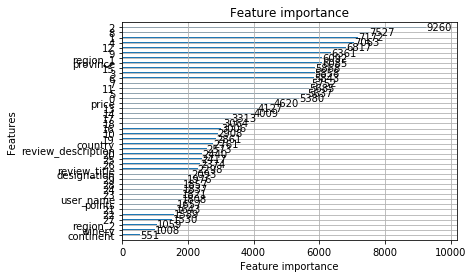

In [48]:
%%time
param = dict()
param['objective'] = 'multiclass'
param['num_class'] = 28
param['metric'] = 'multi_logloss'
param['seed'] = 871
param['learning_rate'] = 0.1
param['is_unbalance'] = True

le = LabelEncoder()
lg_ans = folds(train, le.fit_transform(label.values), lgb, lg_boost = True, param = param, testset = test)

In [58]:
pd.Series(le.inverse_transform(np.argmax(lg_ans,axis = 1))).value_counts()

Pinot Noir                    2697
Chardonnay                    2387
Red Blend                     1984
Cabernet Sauvignon            1915
Bordeaux-style Red Blend      1392
Riesling                      1053
Sauvignon Blanc                945
Syrah                          847
Rosé                           711
Merlot                         608
Nebbiolo                       547
Zinfandel                      519
Sangiovese                     513
Malbec                         509
Portuguese Red                 498
White Blend                    461
Sparkling Blend                423
Tempranillo                    355
Pinot Gris                     303
Grüner Veltliner               277
Portuguese White               266
Cabernet Franc                 258
Rhône-style Red Blend          229
Champagne Blend                226
Bordeaux-style White Blend     207
Gamay                          205
Pinot Grigio                   175
Gewürztraminer                 155
dtype: int64

In [59]:
test.shape

(20665, 42)

In [60]:
test['variety'] = pd.Series(le.inverse_transform(np.argmax(lg_ans,axis = 1)))

In [61]:
test.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,continent,variety
0,7,37,8812,44483,1603,88,3.583519,225,1044,17,1321,0.140780,-0.108010,0.006383,-0.097770,0.116679,-0.019767,0.156904,-0.059482,-0.082299,0.012447,0.029391,-0.000703,-0.012815,-0.007320,-0.013128,0.004661,0.006539,-0.016567,-0.006270,0.023484,-3.180184e-16,7.615445e-08,4.126326e-07,9.392196e-07,5.995637e-07,1.464752e-04,-3.847178e-06,1.314219e-05,2.059212e-05,4.919500e-05,1,Pinot Noir
1,12,0,60204,20268,11665,90,4.110874,182,545,10,9729,0.024846,0.006406,-0.003761,-0.005245,-0.035356,0.000805,0.006106,-0.012301,-0.002615,0.017751,0.061646,0.028833,-0.014544,-0.025979,-0.022495,0.007382,0.041259,0.020699,0.009383,-0.033603,4.653983e-14,2.001209e-04,3.139481e-03,1.928522e-01,3.116132e-05,-2.650815e-03,1.541760e-04,1.126419e-03,7.422088e-04,-8.917954e-04,5,Malbec
2,9,37,69623,54752,28106,87,3.663562,44,256,6,11193,0.027519,-0.001536,0.003069,0.006479,-0.041115,-0.007071,0.016024,0.013991,0.024302,-0.005198,0.040613,-0.008836,-0.040469,-0.003782,-0.001094,-0.025103,-0.010235,0.017205,-0.013139,0.022223,1.000000e+00,1.026254e-16,-1.875793e-18,8.897903e-19,3.718863e-19,5.971914e-19,7.899088e-19,5.107848e-20,3.033712e-18,-3.540232e-18,1,Chardonnay
3,12,0,8251,70957,5084,91,3.044522,182,545,10,1205,0.025387,-0.002091,-0.002155,-0.007016,-0.027582,0.006154,-0.002889,-0.000499,0.005518,0.012495,0.073401,0.032692,0.023519,-0.012430,-0.022315,-0.013792,-0.000419,-0.016829,0.031709,-0.048291,8.008141e-14,1.625949e-03,4.930952e-03,3.231625e-04,7.614723e-04,5.662729e-04,2.901945e-04,1.058852e-01,8.798499e-02,-5.580223e-02,5,Malbec
4,4,19,76627,25814,28106,90,3.912023,321,121,10,12129,0.020474,0.001873,-0.000678,-0.009172,-0.092114,-0.012372,0.064921,-0.036115,0.084407,0.421136,0.085716,0.097631,0.025847,0.058878,-0.015560,-0.016801,-0.014522,0.000938,0.008103,-0.011731,1.000000e+00,1.026254e-16,-1.875793e-18,8.897903e-19,3.718863e-19,5.971914e-19,7.899088e-19,5.107848e-20,3.033712e-18,-3.540232e-18,4,Sangiovese


In [62]:
test.to_csv('FINAL_ANSWER.csv', index = False)

# Current validation F1 Score : 0.932523527346495
# Accuracy Score : 0.9323672743212232

## OTHER THINGS TRIED

BASELINE MODEL: F1_score = 0.60902
Dropped Duplicate values and filled all missing values with mode and median and built final model with LGBM

MODEL 1 = F1_score = 0.9319577 Dropped duplicate filled missing values properly, not PRICE, TFIDF review, desc, 
designation with 10 contents

MODEL 2 = F1_score = 0.93220 Dropped duplicate filled missing values properly, PRICE, TFIDF review, desc, 
designation with 10 contents + points as category

MODEL 3 = F1_score = 0.935376353 Dropped duplicate filled missing values properly, transformed PRICE, TFIDF review, desc, 
designation with 10 contents